# Solving the Traveling Salesman  Problem using Local Search

Points: 10

## The [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

* __Goal:__ Find the shortest tour visiting each of $n$ cities exactly once and returning back to the starting city. Given are pairwise distances between cities, where $d_{i,j}$ is the distance from city $i$ to city $j$. 

* __State space:__ Each state represents a tour. The cities are numbered and a tour can be expressed as vector  $\pi$ with the order in which the cities are visited (a [permutation](https://en.wikipedia.org/wiki/Permutation)). That is, $\pi(1)$ is the index of the first city to visit, $\pi(2)$ the index of the second, and so on.

* __Objective function:__ Minimize the tour length. The optimization problem is to find the optimal tour $\pi^*$ through the $n$ cities and returning to the starting city:

  > minimize: $\mathrm{tourlength}(\pi) = d_{\pi(n),\pi(1)} + \sum_{i = 1}^{n-1} d_{\pi(i),\pi(i+1)}$
  > 
  > subject to: $\pi \ \text{is a valid permutation vector}$

* __Local moves:__ Exchange two cities in the order.

## Helper functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# make the results repeatable
np.random.seed(1234)

In [2]:
def random_tour(n):
    """Create a random tour"""
    
    tour = list(range(n))
    random.shuffle(tour)
    return(tour)

random_tour(10)

[0, 2, 1, 6, 5, 4, 8, 3, 7, 9]

In [3]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a 
    pairwise Euclidean distance matrix.
    """
    
    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })
    
    dist = squareform(pdist(pos))
    
    return({"pos": pos, "dist": dist})
    
tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

Positions:
      x     y
0  0.19  0.36
1  0.62  0.50
2  0.44  0.68
3  0.79  0.71
4  0.78  0.37
5  0.27  0.56
6  0.28  0.50
7  0.80  0.01
8  0.96  0.77
9  0.88  0.88
Distance matrix:
      0     1     2     3     4     5     6     7     8     9
0  0.00  0.45  0.41  0.69  0.59  0.22  0.17  0.70  0.87  0.86
1  0.45  0.00  0.26  0.27  0.20  0.35  0.35  0.52  0.43  0.46
2  0.41  0.26  0.00  0.35  0.46  0.21  0.24  0.76  0.53  0.48
3  0.69  0.27  0.35  0.00  0.34  0.53  0.55  0.70  0.18  0.19
4  0.59  0.20  0.46  0.34  0.00  0.54  0.52  0.36  0.44  0.52
5  0.22  0.35  0.21  0.53  0.54  0.00  0.06  0.76  0.72  0.68
6  0.17  0.35  0.24  0.55  0.52  0.06  0.00  0.72  0.73  0.71
7  0.70  0.52  0.76  0.70  0.36  0.76  0.72  0.00  0.77  0.87
8  0.87  0.43  0.53  0.18  0.44  0.72  0.73  0.77  0.00  0.14
9  0.86  0.46  0.48  0.19  0.52  0.68  0.71  0.87  0.14  0.00)


In [4]:
def tour_length(tsp, tour):
    """Caclulate the length of a tour, i.e., the objective function."""
    
    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()
    
    tl = 0
    dist = tsp["dist"]
    
    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]
    
    tl += dist[tour[-1], tour[0]]
    
    return(tl)
        
tour = random_tour(10)
tour_length(tsp, tour)

np.float64(5.326987094426304)

Tour length: 5.33


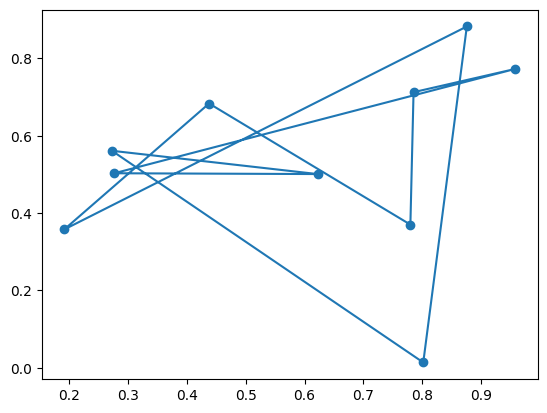

In [7]:
def show_tsp(tsp, tour = None):  
    """display the traveling salesman problem and a tour."""
    
    pos = tsp["pos"]
    
    plt.scatter(pos["x"], pos["y"])
    
    if tour is not None:
        # make sure tour is a Python list (not an array or a numpy.array)
        if not isinstance(tour, list): tour = tour.tolist()
        
        print(f"Tour length: {round(tour_length(tsp, tour), 2)}")
        
        pos_ = pos.reindex(tour)
        #pos_ = pos_.append(pos_.head(1))
        pos_ = pd.concat([pos_, pos_.head(1)])
        plt.plot(pos_["x"], pos_["y"])
    
    plt.show()
    
show_tsp(tsp, tour)

## Use R to find a solution

Load rpy2, make sure the R [TSP package](https://CRAN.R-project.org/package=TSP) is installed and prepare the distance matrix.

In [25]:
%load_ext rpy2.ipython

%R if(!"TSP" %in% rownames(installed.packages())) install.packages("TSP", repos="http://cran.us.r-project.org")
%R if(!"microbenchmark" %in% rownames(installed.packages())) install.packages("microbenchmark", repos="http://cran.us.r-project.org")

d = tsp["dist"]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Solve the TSP using [`solve_TSP`](https://www.rdocumentation.org/packages/TSP/versions/1.1-10/topics/solve_TSP) with the default heuristic. Note that 2-opt is steepest ascend hill climbing with exchanging two cities. `rep=100` means 100 random restarts.

In [26]:
%%R -i d -o tour

library("TSP")

tsp <- TSP(d)
print(tsp)

tour <- solve_TSP(tsp, rep = 100)
print(tour)

# R starts index with 1, but Python starts at 0
tour <- tour - 1L

object of class ‘TSP’ 
10 cities (distance ‘unknown’) 
object of class ‘TOUR’ 
result of method ‘arbitrary_insertion+two_opt_rep_100’ for 10 cities
tour length: 2.763574 


Tour length: 2.76


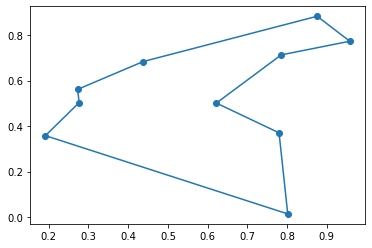

In [27]:
show_tsp(tsp, tour)

How long does it take to solve the problem 100 times?

In [28]:
%%R -i d

library("microbenchmark")

microbenchmark(tsp <- TSP(d))

Unit: microseconds
          expr    min      lq     mean median       uq     max neval
 tsp <- TSP(d) 287.99 302.479 324.9209 312.62 336.2445 616.048   100


## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves.

In [8]:
# Code goes here

import random
import math

# --- Tính tổng chiều dài hành trình ---
def total_distance(route, dist_matrix):
    d = 0
    for i in range(len(route)):
        d += dist_matrix[route[i - 1]][route[i]]
    return d

# --- Sinh một hàng xóm bằng cách hoán đổi 2 thành phố ---
def get_neighbors(route):
    neighbors = []
    for i in range(len(route)):
        for j in range(i + 1, len(route)):
            neighbor = route.copy()
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbors.append(neighbor)
    return neighbors

# --- Thuật toán Steepest-ascent Hill Climbing ---
def hill_climbing_tsp(dist_matrix, max_iterations=1000):
    # Sinh hành trình ngẫu nhiên ban đầu
    current_route = list(range(len(dist_matrix)))
    random.shuffle(current_route)
    current_cost = total_distance(current_route, dist_matrix)

    for step in range(max_iterations):
        neighbors = get_neighbors(current_route)
        best_neighbor = min(neighbors, key=lambda r: total_distance(r, dist_matrix))
        best_cost = total_distance(best_neighbor, dist_matrix)

        if best_cost < current_cost:
            current_route, current_cost = best_neighbor, best_cost
        else:
            break  # Không có cải thiện nữa, dừng lại
    return current_route, current_cost

# --- Ví dụ minh họa ---
# Giả sử có 5 thành phố (khoảng cách đối xứng)
dist_matrix = [
    [0, 2, 9, 10, 7],
    [1, 0, 6, 4, 3],
    [15, 7, 0, 8, 9],
    [6, 3, 12, 0, 11],
    [9, 7, 5, 6, 0]
]

best_route, best_cost = hill_climbing_tsp(dist_matrix)
print("Best route found:", best_route)
print("Best distance:", best_cost)


Best route found: [1, 4, 2, 3, 0]
Best distance: 24


## Steepest-ascend Hill Climbing Search with Random Restarts [1 Point]

Steepest-ascend with random restarts.

In [9]:
# Code goes here
import random

# --- Hàm tính tổng quãng đường ---
def total_distance(route, dist_matrix):
    distance = 0
    for i in range(len(route)):
        distance += dist_matrix[route[i - 1]][route[i]]
    return distance

# --- Sinh tất cả hàng xóm bằng cách hoán đổi 2 thành phố ---
def get_neighbors(route):
    neighbors = []
    for i in range(len(route)):
        for j in range(i + 1, len(route)):
            neighbor = route.copy()
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbors.append(neighbor)
    return neighbors

# --- Thuật toán Hill Climbing cơ bản ---
def hill_climbing_once(dist_matrix, max_iterations=1000):
    current_route = list(range(len(dist_matrix)))
    random.shuffle(current_route)
    current_cost = total_distance(current_route, dist_matrix)

    for _ in range(max_iterations):
        neighbors = get_neighbors(current_route)
        best_neighbor = min(neighbors, key=lambda r: total_distance(r, dist_matrix))
        best_cost = total_distance(best_neighbor, dist_matrix)

        if best_cost < current_cost:
            current_route, current_cost = best_neighbor, best_cost
        else:
            break  # Dừng khi không cải thiện
    return current_route, current_cost

# --- Thuật toán Hill Climbing có Random Restarts ---
def hill_climbing_random_restarts(dist_matrix, restarts=10):
    best_overall_route = None
    best_overall_cost = float("inf")

    for i in range(restarts):
        route, cost = hill_climbing_once(dist_matrix)
        if cost < best_overall_cost:
            best_overall_route, best_overall_cost = route, cost
        print(f"Restart {i+1}: Best local cost = {cost}")
    
    return best_overall_route, best_overall_cost

# --- Ví dụ minh họa ---
dist_matrix = [
    [0, 2, 9, 10, 7],
    [1, 0, 6, 4, 3],
    [15, 7, 0, 8, 9],
    [6, 3, 12, 0, 11],
    [9, 7, 5, 6, 0]
]

best_route, best_cost = hill_climbing_random_restarts(dist_matrix, restarts=10)
print("\nBest overall route:", best_route)
print("Best overall cost:", best_cost)


Restart 1: Best local cost = 24
Restart 2: Best local cost = 24
Restart 3: Best local cost = 24
Restart 4: Best local cost = 24
Restart 5: Best local cost = 24
Restart 6: Best local cost = 24
Restart 7: Best local cost = 24
Restart 8: Best local cost = 24
Restart 9: Best local cost = 24
Restart 10: Best local cost = 24

Best overall route: [2, 3, 1, 0, 4]
Best overall cost: 24


## Stochastic Hill Climbing [1 Points]

Chooses randomly from among all uphill moves.

In [10]:
# Code goes here
import random

# Ví dụ: ma trận khoảng cách giữa các thành phố
dist = [
    [0, 2, 9, 10, 7],
    [1, 0, 6, 4, 3],
    [15, 7, 0, 8, 3],
    [6, 3, 12, 0, 11],
    [9, 7, 5, 6, 0]
]

def cost(tour):
    """Tính tổng quãng đường của hành trình (chu trình khép kín)."""
    total = 0
    for i in range(len(tour)):
        total += dist[tour[i]][tour[(i + 1) % len(tour)]]
    return total

def generate_neighbors(tour):
    """Sinh các hàng xóm bằng cách hoán đổi vị trí của 2 thành phố."""
    neighbors = []
    n = len(tour)
    for i in range(n):
        for j in range(i + 1, n):
            new_tour = tour[:]
            new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
            neighbors.append(new_tour)
    return neighbors

def stochastic_hill_climbing_tsp(dist):
    """Thuật toán Stochastic Hill Climbing cho TSP."""
    # Khởi tạo hành trình ngẫu nhiên
    current = list(range(len(dist)))
    random.shuffle(current)
    current_cost = cost(current)

    while True:
        neighbors = generate_neighbors(current)
        # Chọn các hàng xóm có cost tốt hơn (uphill moves)
        better_neighbors = [n for n in neighbors if cost(n) < current_cost]

        if not better_neighbors:
            # Không có bước đi tốt hơn → đạt local optimum
            break

        # Chọn ngẫu nhiên 1 bước trong số các uphill moves
        current = random.choice(better_neighbors)
        current_cost = cost(current)

    return current, current_cost


# -------------------------------
# Thực thi
# -------------------------------
best_tour, best_cost = stochastic_hill_climbing_tsp(dist)
print("Best tour found:", best_tour)
print("Total cost:", best_cost)



Best tour found: [3, 1, 0, 2, 4]
Total cost: 22


## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state.

In [11]:
# Code goes here
import random

# Ví dụ: ma trận khoảng cách giữa các thành phố
dist = [
    [0, 2, 9, 10, 7],
    [1, 0, 6, 4, 3],
    [15, 7, 0, 8, 3],
    [6, 3, 12, 0, 11],
    [9, 7, 5, 6, 0]
]

def cost(tour):
    """Tính tổng quãng đường của hành trình (chu trình khép kín)."""
    total = 0
    for i in range(len(tour)):
        total += dist[tour[i]][tour[(i + 1) % len(tour)]]
    return total

def random_neighbor(tour):
    """Sinh ngẫu nhiên 1 hàng xóm bằng cách hoán đổi 2 vị trí."""
    n = len(tour)
    i, j = random.sample(range(n), 2)
    neighbor = tour[:]
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

def first_choice_hill_climbing_tsp(dist, max_iterations=1000):
    """Thuật toán First-choice Hill Climbing cho TSP."""
    # Khởi tạo hành trình ngẫu nhiên
    current = list(range(len(dist)))
    random.shuffle(current)
    current_cost = cost(current)

    for _ in range(max_iterations):
        # Sinh ngẫu nhiên 1 hàng xóm
        neighbor = random_neighbor(current)
        neighbor_cost = cost(neighbor)

        # Nếu hàng xóm tốt hơn → chấp nhận ngay
        if neighbor_cost < current_cost:
            current = neighbor
            current_cost = neighbor_cost

    return current, current_cost


# ------------------------------------------
# Thực thi
# ------------------------------------------
best_tour, best_cost = first_choice_hill_climbing_tsp(dist)
print("Best tour found:", best_tour)
print("Total cost:", best_cost)


Best tour found: [3, 1, 0, 2, 4]
Total cost: 22


## Simulated Annealing [2 Points]

In [12]:
# Code goes here
import math
import random

# ======== Hàm tính khoảng cách giữa 2 thành phố ========
def distance(city1, city2):
    return math.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)

# ======== Tổng độ dài một tour ========
def total_distance(tour, cities):
    return sum(distance(cities[tour[i]], cities[tour[(i + 1) % len(tour)]])
               for i in range(len(tour)))

# ======== Tạo hàng xóm (neighbor) bằng cách hoán đổi 2 vị trí ========
def get_neighbor(tour):
    i, j = random.sample(range(len(tour)), 2)
    new_tour = tour[:]
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

# ======== Simulated Annealing Algorithm ========
def simulated_annealing(cities, T0=1000, Tmin=1e-3, alpha=0.995, max_iter=100000):
    current_tour = list(range(len(cities)))
    random.shuffle(current_tour)
    current_distance = total_distance(current_tour, cities)
    best_tour = current_tour[:]
    best_distance = current_distance

    T = T0
    iteration = 0

    while T > Tmin and iteration < max_iter:
        new_tour = get_neighbor(current_tour)
        new_distance = total_distance(new_tour, cities)
        delta = new_distance - current_distance

        # Nếu tốt hơn, nhận luôn
        if delta < 0 or math.exp(-delta / T) > random.random():
            current_tour = new_tour
            current_distance = new_distance
            # Cập nhật lời giải tốt nhất
            if current_distance < best_distance:
                best_tour = current_tour[:]
                best_distance = current_distance

        # Giảm nhiệt độ dần
        T *= alpha
        iteration += 1

        # In ra mỗi 5000 vòng để theo dõi
        if iteration % 5000 == 0:
            print(f"Iteration {iteration} | Temp={T:.4f} | Best Distance={best_distance:.2f}")

    return best_tour, best_distance

# ======== Danh sách các thành phố (ví dụ 8 điểm ngẫu nhiên) ========
cities = [
    (0, 0), (2, 6), (3, 2), (5, 8),
    (8, 3), (7, 7), (6, 1), (1, 5)
]

# ======== Chạy thuật toán SA ========
best_tour, best_distance = simulated_annealing(cities)

print("\nBest route found:", best_tour)
print("Shortest distance:", round(best_distance, 2))



Best route found: [5, 4, 6, 2, 0, 7, 1, 3]
Shortest distance: 26.07


## Compare Performance [2 Points]

Use runtime, scalability (number of cities), and best objective function value to compare the algorithms on boards of different sizes.  

For timing you can use the `time` package.

In [13]:
import time

t0 = time.time()
print("Do something")
t1 = time.time()

print(f"This took: {(t1-t0) * 1e3} milliseconds")

Do something
This took: 0.0 milliseconds


In [14]:
# Code and results go here
import random
import math
import time

# ----------------------------
# DỮ LIỆU MẪU TSP (5 thành phố)
# ----------------------------
dist = [
    [0, 2, 9, 10, 7],
    [1, 0, 6, 4, 3],
    [15, 7, 0, 8, 3],
    [6, 3, 12, 0, 11],
    [9, 7, 5, 6, 0]
]

# ----------------------------
# HÀM TÍNH CHI PHÍ HÀNH TRÌNH
# ----------------------------
def cost(tour):
    total = 0
    for i in range(len(tour)):
        total += dist[tour[i]][tour[(i + 1) % len(tour)]]
    return total

def random_neighbor(tour):
    """Hoán đổi ngẫu nhiên 2 thành phố"""
    i, j = random.sample(range(len(tour)), 2)
    neighbor = tour[:]
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

# ============================================================
# 1 Steepest-ascent Hill Climbing
# ============================================================
def steepest_ascent(dist, max_iterations=1000):
    current = list(range(len(dist)))
    random.shuffle(current)
    current_cost = cost(current)

    for _ in range(max_iterations):
        neighbors = [random_neighbor(current) for _ in range(50)]
        best_neighbor = min(neighbors, key=cost)
        best_cost = cost(best_neighbor)
        if best_cost < current_cost:
            current, current_cost = best_neighbor, best_cost
        else:
            break
    return current, current_cost


# ============================================================
# 2 Steepest-ascent with Random Restarts
# ============================================================
def steepest_ascent_random_restarts(dist, restarts=10):
    best_overall = None
    best_cost = float('inf')
    for _ in range(restarts):
        tour, c = steepest_ascent(dist)
        if c < best_cost:
            best_overall, best_cost = tour, c
    return best_overall, best_cost


# ============================================================
# 3 Stochastic Hill Climbing
# ============================================================
def stochastic_hill_climbing(dist, max_iterations=1000):
    current = list(range(len(dist)))
    random.shuffle(current)
    current_cost = cost(current)

    for _ in range(max_iterations):
        neighbors = [random_neighbor(current) for _ in range(20)]
        better_neighbors = [n for n in neighbors if cost(n) < current_cost]
        if not better_neighbors:
            break
        current = random.choice(better_neighbors)
        current_cost = cost(current)
    return current, current_cost


# ============================================================
# 4 First-choice Hill Climbing
# ============================================================
def first_choice_hill_climbing(dist, max_iterations=1000):
    current = list(range(len(dist)))
    random.shuffle(current)
    current_cost = cost(current)

    for _ in range(max_iterations):
        neighbor = random_neighbor(current)
        neighbor_cost = cost(neighbor)
        if neighbor_cost < current_cost:
            current, current_cost = neighbor, neighbor_cost
    return current, current_cost


# ============================================================
# 5 Simulated Annealing
# ============================================================
def simulated_annealing(dist, T=1000.0, alpha=0.995, max_iterations=1000):
    current = list(range(len(dist)))
    random.shuffle(current)
    current_cost = cost(current)
    best, best_cost = current, current_cost

    for _ in range(max_iterations):
        neighbor = random_neighbor(current)
        neighbor_cost = cost(neighbor)
        delta = neighbor_cost - current_cost

        if delta < 0 or random.random() < math.exp(-delta / T):
            current, current_cost = neighbor, neighbor_cost
            if current_cost < best_cost:
                best, best_cost = current, current_cost
        T *= alpha
    return best, best_cost


# ============================================================
# So sánh hiệu năng giữa các thuật toán
# ============================================================
algorithms = {
    "Steepest-ascent": steepest_ascent,
    "Random Restarts": steepest_ascent_random_restarts,
    "Stochastic HC": stochastic_hill_climbing,
    "First-choice HC": first_choice_hill_climbing,
    "Simulated Annealing": simulated_annealing
}

results = []

for name, algo in algorithms.items():
    start = time.time()
    tour, c = algo(dist)
    elapsed = time.time() - start
    results.append((name, c, elapsed))

# ============================================================
# In kết quả
# ============================================================
print(f"{'Algorithm':<25}{'Best Cost':<15}{'Time (s)':<10}")
print("-" * 50)
for name, c, t in results:
    print(f"{name:<25}{c:<15.2f}{t:<10.4f}")



Algorithm                Best Cost      Time (s)  
--------------------------------------------------
Steepest-ascent          22.00          0.0000    
Random Restarts          22.00          0.0060    
Stochastic HC            22.00          0.0000    
First-choice HC          22.00          0.0098    
Simulated Annealing      22.00          0.0050    


## Bonus: Genetic Algorithm [+1 Point]

In [15]:
# Code goes here
import random
import math

# ======== TSP Distance Function ========
def distance(city1, city2):
    return math.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)

def total_distance(tour, cities):
    dist = 0
    for i in range(len(tour)):
        dist += distance(cities[tour[i]], cities[tour[(i + 1) % len(tour)]])
    return dist

# ======== Genetic Algorithm ========
def initial_population(pop_size, num_cities):
    population = []
    for _ in range(pop_size):
        tour = list(range(num_cities))
        random.shuffle(tour)
        population.append(tour)
    return population

def fitness(tour, cities):
    return 1 / total_distance(tour, cities)

def selection(population, cities):
    # Chọn 2 cá thể theo giải pháp roulette wheel
    weights = [fitness(t, cities) for t in population]
    return random.choices(population, weights=weights, k=2)

def crossover(parent1, parent2):
    start, end = sorted(random.sample(range(len(parent1)), 2))
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]
    pointer = 0
    for city in parent2:
        if city not in child:
            while child[pointer] is not None:
                pointer += 1
            child[pointer] = city
    return child

def mutate(tour, mutation_rate=0.02):
    for i in range(len(tour)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(tour) - 1)
            tour[i], tour[j] = tour[j], tour[i]

def genetic_algorithm(cities, pop_size=100, generations=500, mutation_rate=0.02):
    population = initial_population(pop_size, len(cities))
    best_tour = min(population, key=lambda t: total_distance(t, cities))
    best_distance = total_distance(best_tour, cities)

    for gen in range(generations):
        new_population = []

        for _ in range(pop_size):
            parent1, parent2 = selection(population, cities)
            child = crossover(parent1, parent2)
            mutate(child, mutation_rate)
            new_population.append(child)

        population = new_population

        current_best = min(population, key=lambda t: total_distance(t, cities))
        current_distance = total_distance(current_best, cities)

        if current_distance < best_distance:
            best_tour, best_distance = current_best, current_distance

        if gen % 50 == 0:
            print(f"Generation {gen}: Best Distance = {best_distance:.2f}")

    return best_tour, best_distance

# ======== Example Cities ========
cities = [
    (0, 0), (2, 6), (3, 2), (5, 8),
    (8, 3), (7, 7), (6, 1), (1, 5)
]

best_tour, best_distance = genetic_algorithm(cities)
print("\nBest route found:", best_tour)
print("Shortest distance:", round(best_distance, 2))


Generation 0: Best Distance = 27.50
Generation 50: Best Distance = 26.07
Generation 100: Best Distance = 26.07
Generation 150: Best Distance = 26.07
Generation 200: Best Distance = 26.07
Generation 250: Best Distance = 26.07
Generation 300: Best Distance = 26.07
Generation 350: Best Distance = 26.07
Generation 400: Best Distance = 26.07
Generation 450: Best Distance = 26.07

Best route found: [1, 3, 5, 4, 6, 2, 0, 7]
Shortest distance: 26.07
